In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import util.data_proc as dp
import util.im_stats as imstat
import util.pipeline as pipe

from sigpy.plot import ImagePlot, LinePlot

plt.rcParams['savefig.dpi']=300

# print("Num GPUs: {}".format(torch.cuda.device_count()))
torch.cuda.set_device(0)
print("Currently using GPU {}".format(torch.cuda.current_device()))

pre_run = True # Determines whether to use saved results or to rerun the network

Currently using GPU 1


In [3]:
%matplotlib notebook

In [4]:
raw_filename = 'data/raw/t1_icbm_normal_1mm_pn0_rf20.mnc'
im_vol = dp.read_data(raw_filename, img=True)
file_path = "data/out/denoise/"

# Denoising

### Data Generation

Image Volume Shape: (181, 217, 181)
Image Center Slices Shape: (10, 217, 181)


<IPython.core.display.Javascript object>


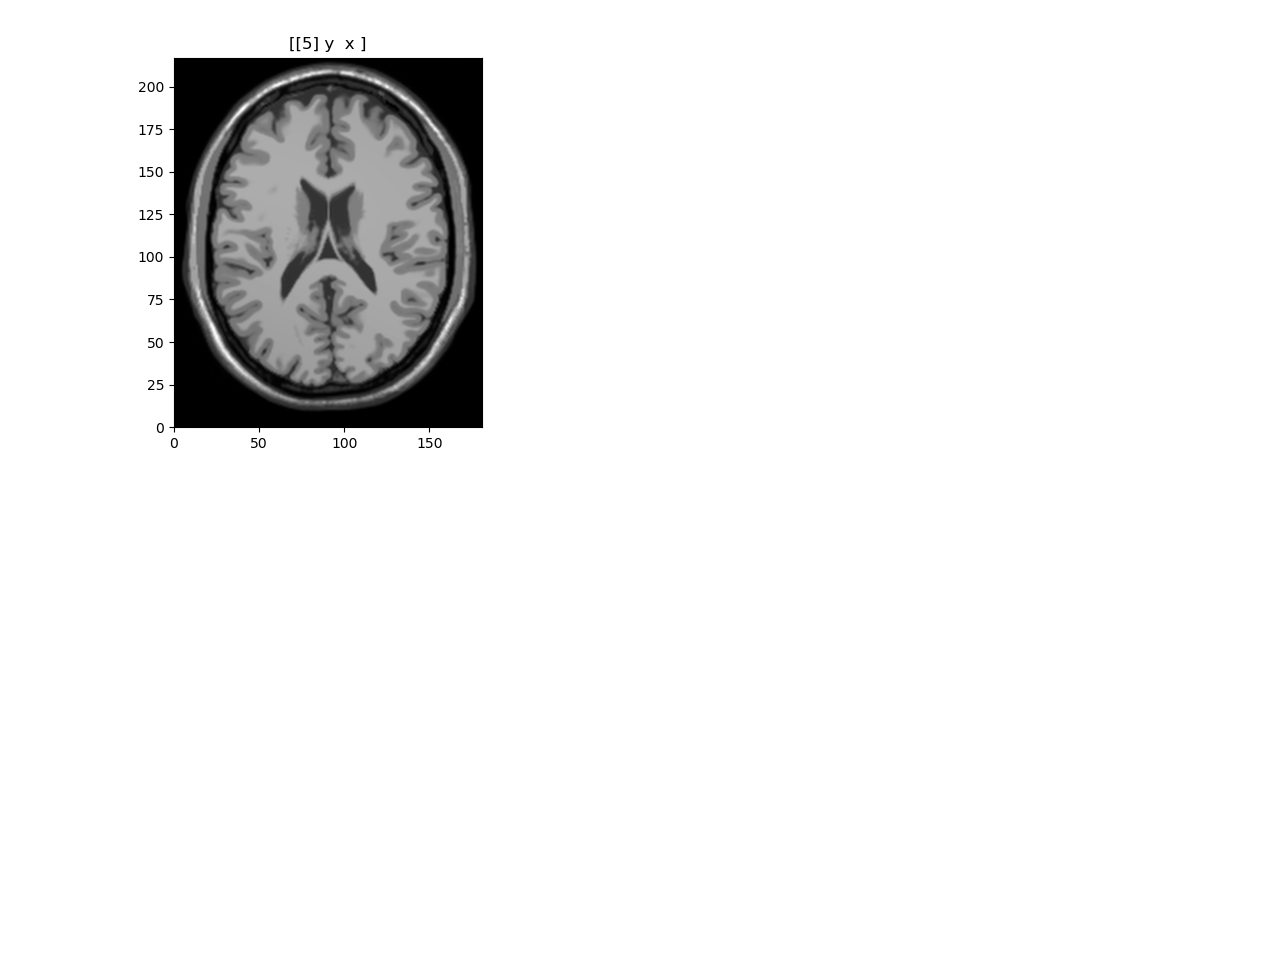

In [5]:
c = im_vol.shape[0]//2
w = 10
im_slices = im_vol[c-w//2:c+w//2]

print("Image Volume Shape: {}".format(im_vol.shape))
print("Image Center Slices Shape: {}".format(im_slices.shape))
ImagePlot(im_slices);

<IPython.core.display.Javascript object>


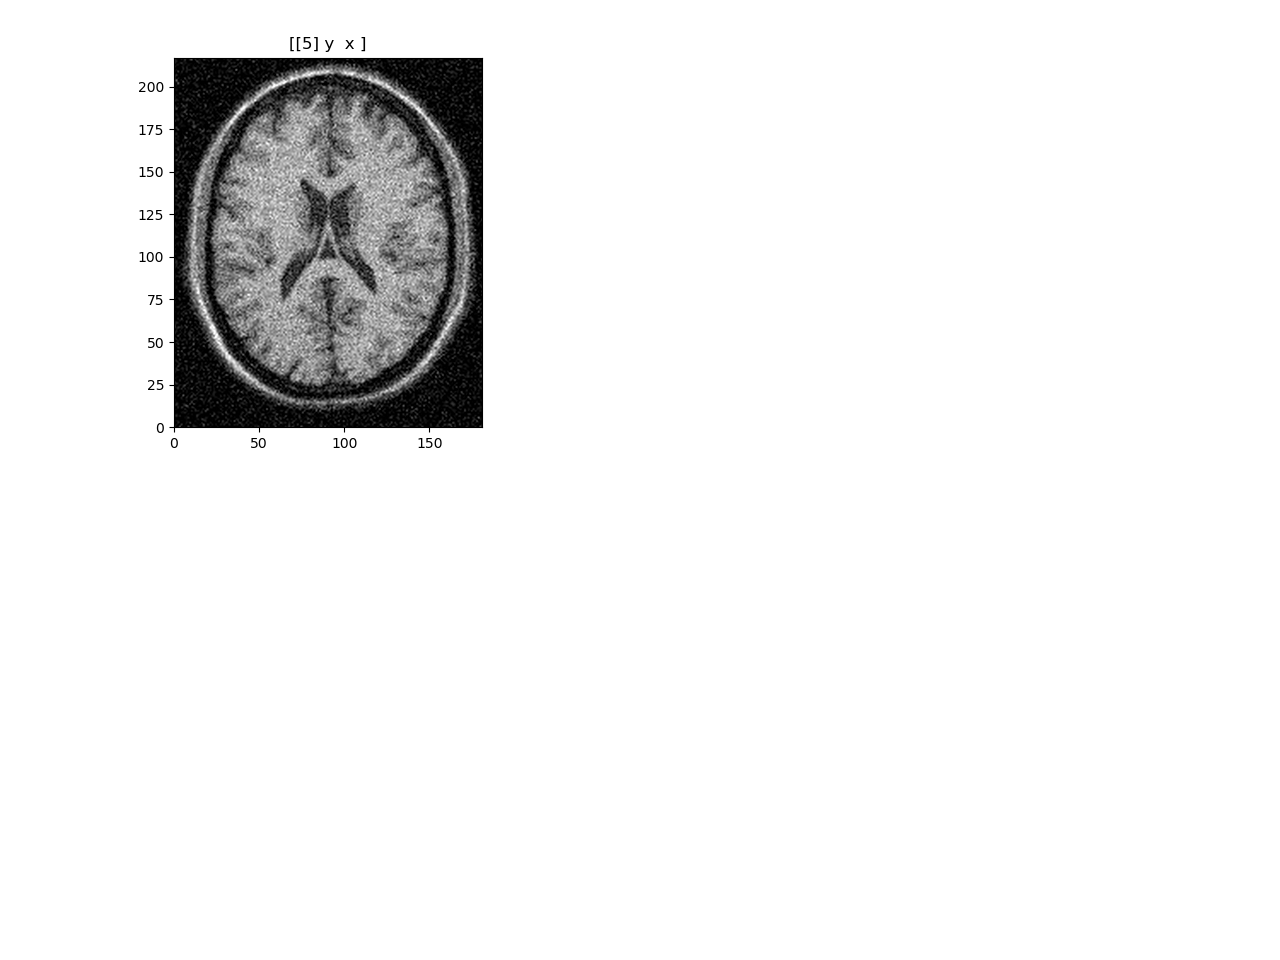

In [6]:
# #Noisy slice gen - run once and then read from disk
# noisy_slices = np.stack([dp.gen_noisy_img(sl, 10) for sl in im_slices])
# np.save(file_path+"noisy_slices", noisy_slices)

#Noisy slice read
noisy_slices = np.load(file_path+"noisy_slices.npy")
ImagePlot(noisy_slices);

In [7]:
print(*["Slice {:2d}: PSNR {:.2f}".format(i+1,imstat.psnr(im_slices[i], noisy_slices[i])) for i in range(im_slices.shape[0])],sep="\n")

Slice  1: PSNR 20.79
Slice  2: PSNR 20.81
Slice  3: PSNR 20.78
Slice  4: PSNR 20.88
Slice  5: PSNR 20.82
Slice  6: PSNR 20.82
Slice  7: PSNR 20.84
Slice  8: PSNR 20.84
Slice  9: PSNR 20.89
Slice 10: PSNR 20.79


## BM3D Denoising

As mentioned [here](https://github.com/ericmjonas/pybm3d/issues/8), pybm3d has issues on Ubuntu, so I ran the BM3D denoising on a separate machine and included the results in `bm3d_denoise.npy`

<IPython.core.display.Javascript object>


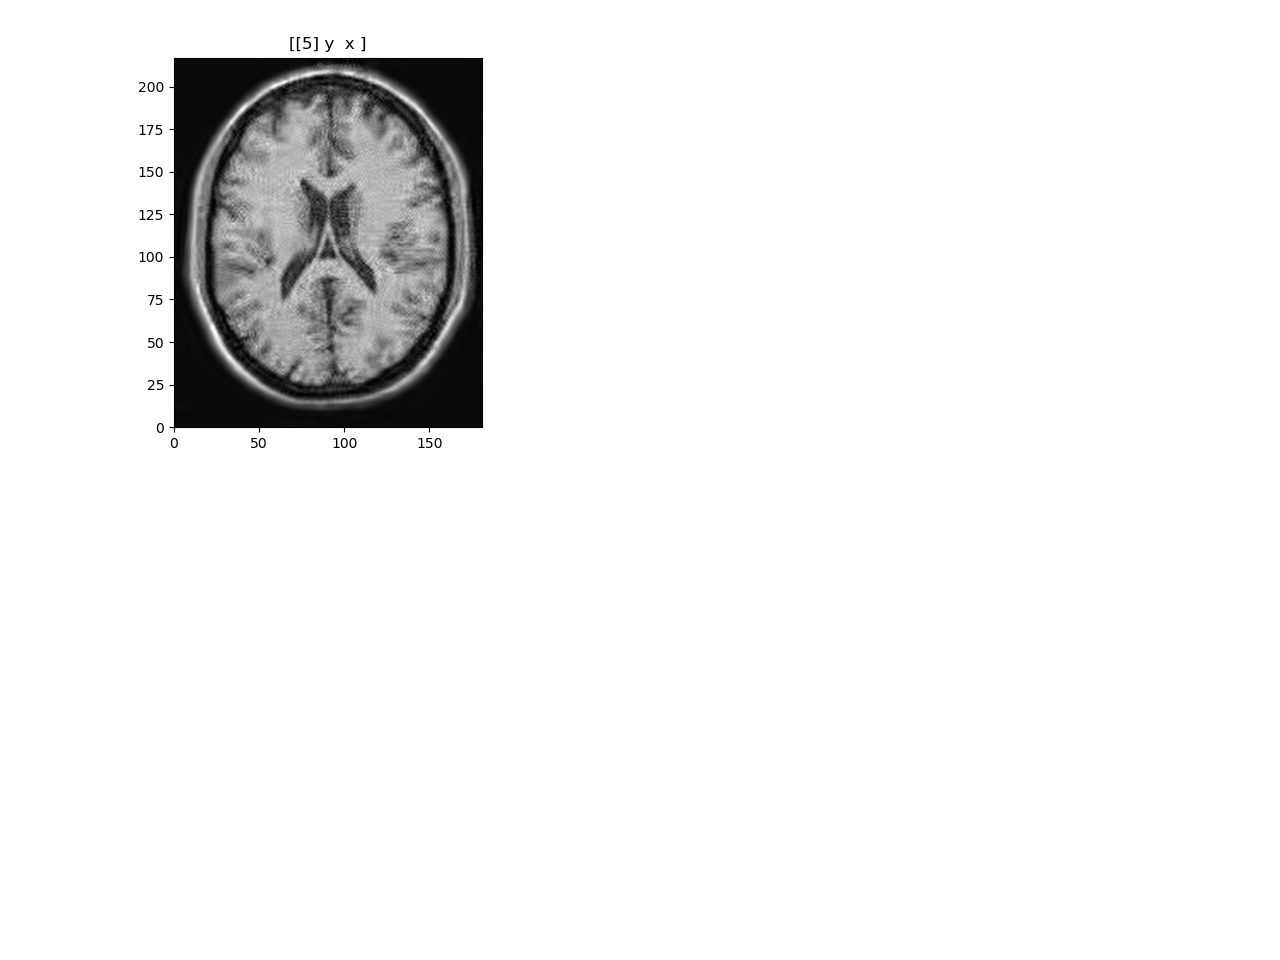

In [8]:
bm3d_den_ims = np.load(file_path+"bm3d_denoise.npy")
ImagePlot(np.stack(bm3d_den_ims));

In [9]:
print(*["Slice {:2d}: PSNR {:.2f}".format(i+1,imstat.psnr(im_slices[i], bm3d_den_ims[i])) for i in range(im_slices.shape[0])],sep="\n")

Slice  1: PSNR 27.05
Slice  2: PSNR 27.18
Slice  3: PSNR 27.14
Slice  4: PSNR 27.34
Slice  5: PSNR 27.29
Slice  6: PSNR 27.37
Slice  7: PSNR 27.33
Slice  8: PSNR 27.43
Slice  9: PSNR 27.39
Slice 10: PSNR 27.22


 ## Individual Denoising

In [10]:
#Independent denoising
indep_den_ims = np.zeros_like(noisy_slices)

In [11]:
if pre_run:
    indep_den_ims = np.load(file_path+"indep_denoise.npy")
else:
    for i in range(im_slices.shape[0]):
        print("Denoising Slice #{}".format(i))
        indep_den_ims[i],mse,net = pipe.single_recon(noisy_slices[i], k=64, niter=10000, verbose=False)

<IPython.core.display.Javascript object>


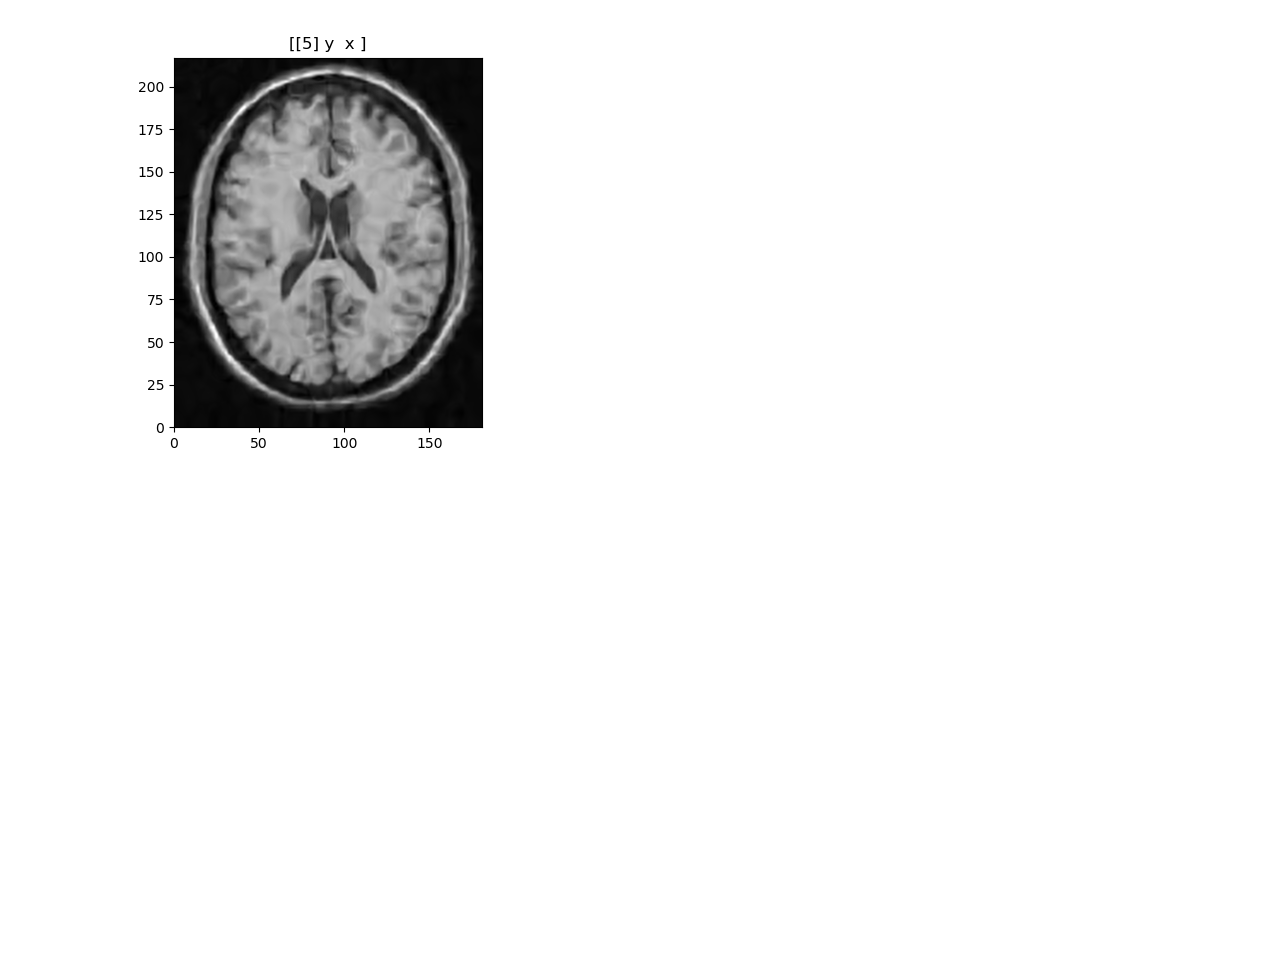

In [12]:
ImagePlot(np.stack(indep_den_ims));

In [13]:
print(*["Slice {:2d}: PSNR {:.2f}".format(i+1,imstat.psnr(im_slices[i], indep_den_ims[i])) for i in range(im_slices.shape[0])],sep="\n")

Slice  1: PSNR 27.65
Slice  2: PSNR 27.90
Slice  3: PSNR 27.81
Slice  4: PSNR 27.99
Slice  5: PSNR 27.82
Slice  6: PSNR 27.91
Slice  7: PSNR 28.00
Slice  8: PSNR 28.03
Slice  9: PSNR 28.13
Slice 10: PSNR 28.00


## Multislice Denoise

In [14]:
#(Joint) denoising
if pre_run:
    joint_den_ims = np.load(file_path+"join_denoise.npy")
else:
    joint_noisy_ims = [noisy_sl for noisy_sl in noisy_slices]
    joint_den_ims,mse,net = pipe.multichannel_recon(joint_noisy_ims, k=64, niter=10000, verbose=True)
    plt.figure()
    plt.loglog(mse);

<IPython.core.display.Javascript object>


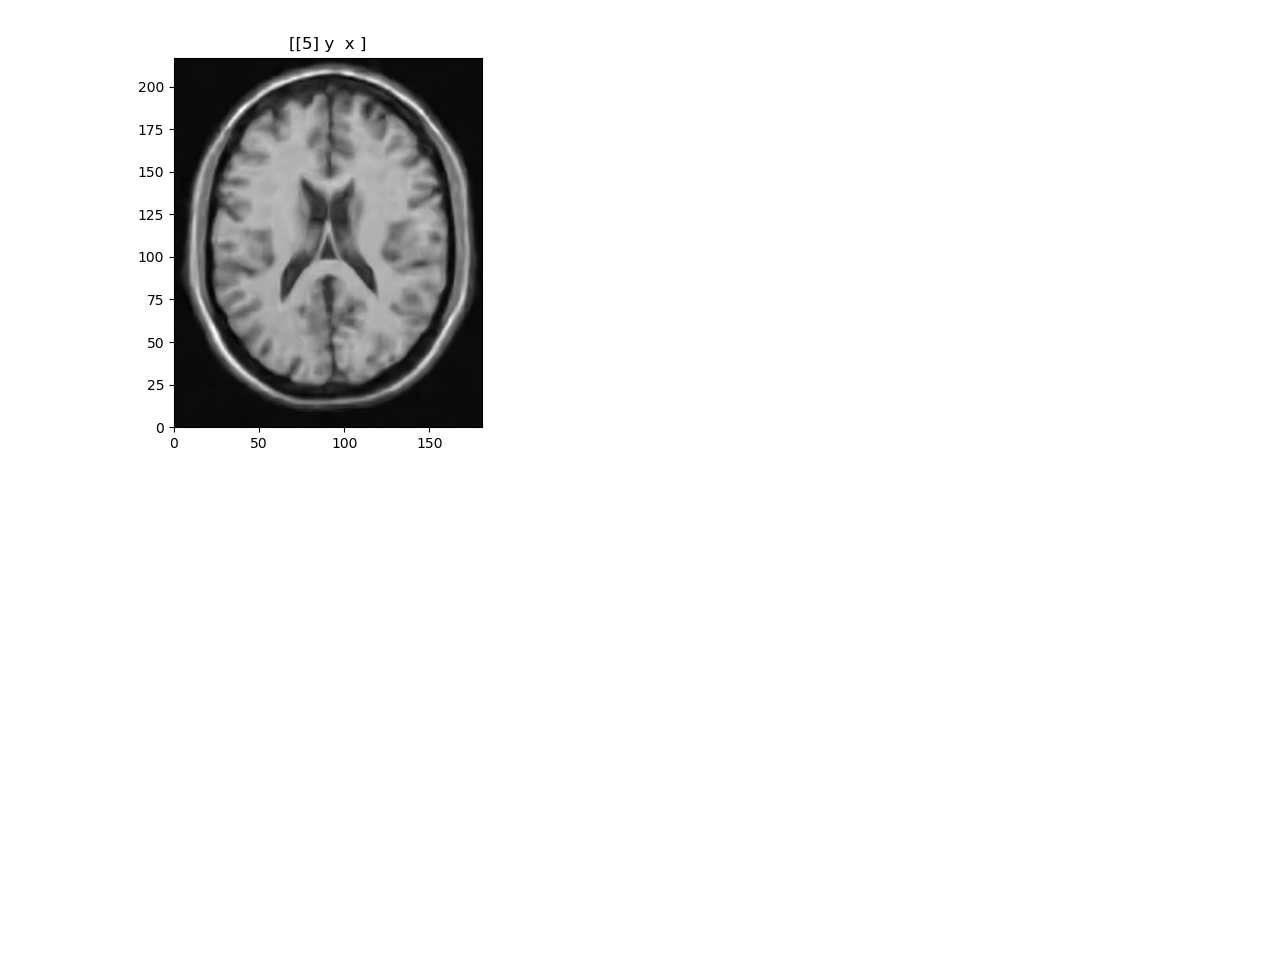

In [15]:
ImagePlot(np.stack(joint_den_ims));

In [16]:
print(*["Slice {:2d}: PSNR {:.2f}".format(i+1,imstat.psnr(im_slices[i], joint_den_ims[i])) for i in range(im_slices.shape[0])],sep="\n")

Slice  1: PSNR 27.73
Slice  2: PSNR 28.50
Slice  3: PSNR 28.51
Slice  4: PSNR 28.61
Slice  5: PSNR 28.48
Slice  6: PSNR 28.59
Slice  7: PSNR 28.72
Slice  8: PSNR 28.76
Slice  9: PSNR 28.82
Slice 10: PSNR 28.11


<IPython.core.display.Javascript object>


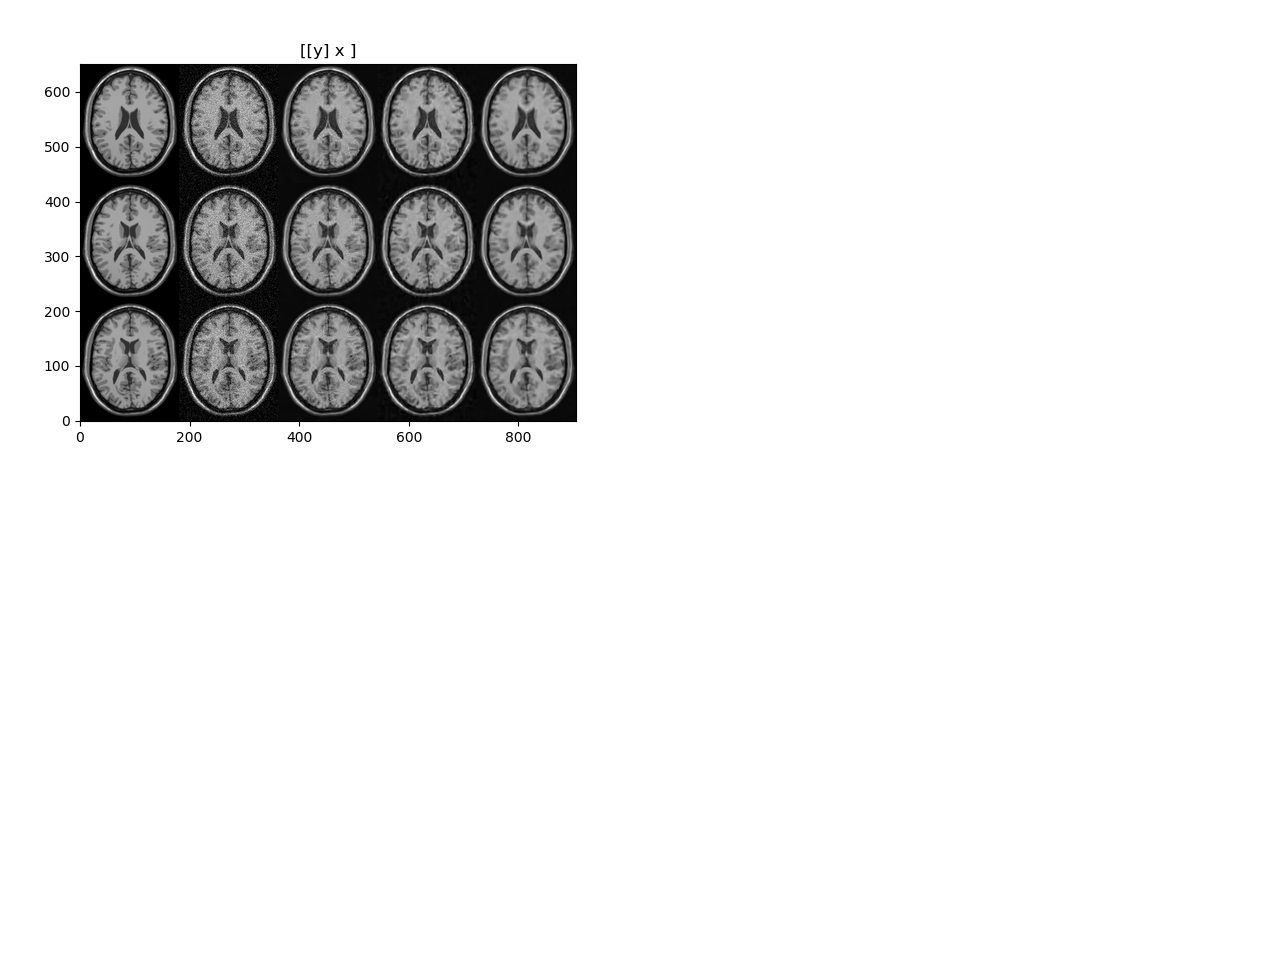

PSNR for Slices:
 BM3D | Indep | Joint
27.05 | 27.65 | 27.73
27.29 | 27.82 | 28.48
27.39 | 28.13 | 28.82


In [17]:
s = [0,4,8]
ImagePlot(np.vstack([np.concatenate((im_slices[i],noisy_slices[i],bm3d_den_ims[i],indep_den_ims[i],joint_den_ims[i]),axis=1) for i in s]))
# plt.savefig(file_path+"denoise_res.png")
print("PSNR for Slices:")
print(" BM3D | Indep | Joint")
for i in s:
    print(*["{:.2f}".format(imstat.psnr(im_slices[i], obj)) for obj in [bm3d_den_ims[i], indep_den_ims[i], joint_den_ims[i]]], sep=" | ")